Libraries

In [14]:
import bikescience.load_trips as tr
import bikescience.stations as st
from bikescience.grid import Grid
import bikescience.flow as flow

import pandas as pd
import os
import glob
from haversine import haversine, Unit
import geopandas as gpd
from matplotlib import pyplot as plt

folder = '../../data/boston/training-sets/processing/'
od_id = ['i_start', 'j_start', 'i_end', 'j_end']

Input data

In [2]:
trips_folder = '../../data/boston/bike-trips/'
trips = tr.load_trips_files([
    trips_folder + '201804-hubway-tripdata.csv',
    trips_folder + '201805-bluebikes-tripdata.csv',
    trips_folder + '201806-bluebikes-tripdata.csv',
    trips_folder + '201807-bluebikes-tripdata.csv',
    trips_folder + '201808-bluebikes-tripdata.csv',
    trips_folder + '201809-bluebikes-tripdata.csv',
    trips_folder + '201810-bluebikes-tripdata.csv',
    trips_folder + '201811-bluebikes-tripdata.csv',
    trips_folder + '201812-bluebikes-tripdata.csv',
    trips_folder + '201901-bluebikes-tripdata.csv',
    trips_folder + '201902-bluebikes-tripdata.csv',
    trips_folder + '201903-bluebikes-tripdata.csv',
])
trips['per_hour'] = trips['starttime'].dt.to_period('h')
print(len(trips), 'trips')
trips.head()

1853732 trips


tripduration               starttime                stoptime  \
0          2254 2018-04-01 00:03:32.942 2018-04-01 00:41:07.789   
1          2376 2018-04-01 00:04:25.323 2018-04-01 00:44:01.394   
2          2083 2018-04-01 00:04:38.845 2018-04-01 00:39:21.956   
3          1547 2018-04-01 00:05:21.257 2018-04-01 00:31:08.497   
4           271 2018-04-01 00:05:51.608 2018-04-01 00:10:23.530   

   start station id            start station name  start station latitude  \
0                33                Kenmore Square               42.348706   
1                33                Kenmore Square               42.348706   
2                33                Kenmore Square               42.348706   
3                81  Boylston St at Washington St               42.352409   
4                67  MIT at Mass Ave / Amherst St               42.358100   

   start station longitude  end station id  \
0               -71.097009              70   
1               -71.097009              73   
2               -71.097009              70   
3               -71.062679              97   
4               -71.093198             179   

                                    end station name  end station latitude  \
0    Harvard Kennedy School at Bennett St / Eliot St             42.372217   
1            Harvard Square at Brattle St / Eliot St             42.373231   
2    Harvard Kennedy School at Bennett St / Eliot St             42.372217   
3  Harvard University River Houses at DeWolfe St ...             42.369190   
4                                      MIT Vassar St             42.355601   

   ...  bikeid    usertype birth year  gender     per_day hour  week_day  \
0  ...    1253    Customer       1969       0  2018-04-01    0         6   
1  ...    1658    Customer       1969       0  2018-04-01    0         6   
2  ...    1579    Customer       1969       0  2018-04-01    0         6   
3  ...    1459  Subscriber       1987       2  2018-04-01    0         6   
4  ...     184  Subscriber       1993       1  2018-04-01    0         6   

   weekend  holiday          per_hour  
0     True    False  2018-04-01 00:00  
1     True    False  2018-04-01 00:00  
2     True    False  2018-04-01 00:00  
3     True    False  2018-04-01 00:00  
4     True    False  2018-04-01 00:00  

[5 rows x 21 columns]

In [3]:
stations = st.from_trips(trips)
print(len(stations), 'stations')

319 stations


## TODO

Try 2 different grid placements and compare the results.

In [9]:
grid = Grid()

General flows
* Use for those time-consuming processings

In [ ]:
flow.od_countings(trips, grid, stations).to_csv(folder + 'general-flows.csv', index=False)

Consider all grid cells with stations, even if there are no flow between any of them

In [5]:
with_st = gpd.sjoin(grid.geodataframe(), stations, op='contains')
with_st = gpd.GeoDataFrame(with_st[['i', 'j']].drop_duplicates().merge(grid.geodataframe()))
print(len(with_st))
with_st.head()

163


i   j                                           geometry
0  0  11  POLYGON ((-71.0708152 42.29519999999999, -71.0...
1  0  13  POLYGON ((-71.05463589999999 42.29519999999999...
2  1   7  POLYGON ((-71.10317379999999 42.3012051, -71.1...
3  1  10  POLYGON ((-71.07890485 42.3012051, -71.0789048...
4  2   6  POLYGON ((-71.11126345 42.30721019999999, -71....

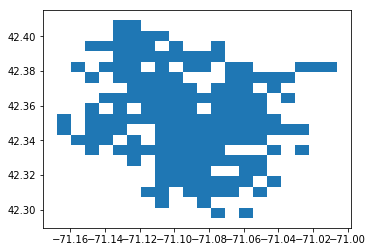

In [6]:
with_st.plot()

In [7]:
with_st['fake_id'] = 42
combinations = with_st.merge(with_st, on='fake_id', suffixes=('_start', '_end'))[od_id]
combinations.head()

i_start  j_start  i_end  j_end                                  origin  \
0        0       11      0     11  POINT (-71.07486002499999 42.29820255)   
1        0       11      0     13  POINT (-71.07486002499999 42.29820255)   
2        0       11      1      7  POINT (-71.07486002499999 42.29820255)   
3        0       11      1     10  POINT (-71.07486002499999 42.29820255)   
4        0       11      2      6  POINT (-71.07486002499999 42.29820255)   

                                    destination  
0        POINT (-71.07486002499999 42.29820255)  
1        POINT (-71.05868072499999 42.29820255)  
2             POINT (-71.107218625 42.30420765)  
3        POINT (-71.08294967500001 42.30420765)  
4  POINT (-71.11530827499999 42.31021274999998)

Flows per month and day period/type

In [12]:
trips['month'] = trips.starttime.dt.to_period('m').dt.to_timestamp()
months = trips.month.unique()
months

array(['2018-04-01T00:00:00.000000000', '2018-05-01T00:00:00.000000000',
       '2018-06-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2018-08-01T00:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2018-11-01T00:00:00.000000000',
       '2018-12-01T00:00:00.000000000', '2019-01-01T00:00:00.000000000',
       '2019-02-01T00:00:00.000000000', '2019-03-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [ ]:
period_names = ['morning', 'lunchtime', 'afternoon']
periods = [tr.morning(trips), tr.lunchtime(trips), tr.afternoon(trips)]
idx = 0

for period in periods:
    print('Period:', period_names[idx])
    for month in months:
        month_str = pd.to_datetime(month).strftime('%Y%m')
        print('   Month:', month_str)
        for weekend in [False, True]:
            weekend_str = 'weekend-holiday' if weekend else 'working-day'
            print('      ', weekend_str)
            csv = folder + 'tmp/' + month_str + '-' + period_names[idx] + '-' + weekend_str + '.csv'
            if os.path.isfile(csv): 
                print('       --- already processed')
                continue
            weekend_filter = (period.weekend | period.holiday) if weekend else ~(period.weekend | period.holiday)
            filtered = period[(period.month == month) & weekend_filter]
            od = flow.od_countings(filtered, grid, stations)
            od = od[od_id + ['trip counts']]
            od = combinations.merge(od, on=od_id, how='left').fillna(0)
            od = od[(od.i_start != od.i_end) | (od.j_start != od.j_end)]
            od['period'] = idx
            od['distance'] = od.apply(
                lambda r: haversine((r.origin.y, r.origin.x), (r.destination.y, r.destination.x), unit=Unit.METERS),
                axis=1)
            od['month'] = month
            od['weekend_or_holiday'] = 1 if weekend else 0
            od.to_csv(csv, index=False)
    idx += 1

Period: morning
   Month: 201804
       working-day
       weekend-holiday
   Month: 201805
       working-day
       weekend-holiday


In [ ]:
od_files = glob.glob(folder + 'tmp/*.csv')
od_list = []

for f in od_files:
    od = pd.read_csv(f)
    od_list.append(od)

od_samples = pd.concat(od_list, sort=False)
od_samples.to_csv(folder + 'month-daytype-dayperiod-flows-with-zeros.csv', index=False)
print(len(od_samples), 'flows')
od_samples.head(20)

In [ ]:
# previously saved file
od_samples = pd.read_csv(folder + 'month-daytype-dayperiod-flows-with-zeros.csv')
print(len(od_samples), 'flows')
od_samples.head()

Some descriptive analysis

In [ ]:
trip_counts = od_samples['trip counts']

In [ ]:
trip_counts.min()

In [ ]:
trip_counts.max()

In [ ]:
mean = trip_counts.mean()
mean

In [ ]:
std = trip_counts.std()
std

In [ ]:
plt.hist(trip_counts, bins=100)
plt.show()

In [ ]:
plt.hist(trip_counts[trip_counts > 0], bins=100)
plt.show()

* **Outliers** are what we are searching for!
  * Flows with a large numer of trips

In [ ]:
outliers = trip_counts[trip_counts > 10]
len(outliers)

In [ ]:
plt.hist(outliers, bins=100)
plt.show()